---

## CIFAR 10

data from fast.ai

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH, exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz, bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad = sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
bs = 64

#### Viewing Data:

In [29]:
data = get_data(32, 4)

In [30]:
x, y = next(iter(data.trn_dl))

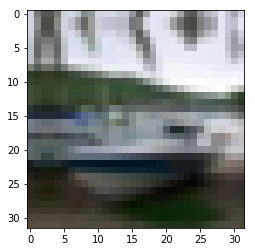

In [31]:
plt.imshow(data.trn_ds.denorm(x)[0]);

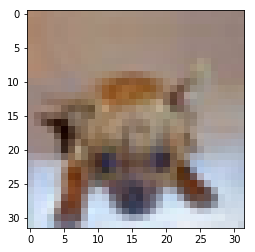

In [32]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Learner Initialization Tests

From this [fast.ai forum thread](http://forums.fast.ai/t/project-implement-yolo-v3-backbone-and-preact-resnet/14613/51?u=borz). Looking at how the loss function is determined when a Learner is initialized from scratch or from a pretrained model.

**NOTE**: `fastai.conv_learner` edited to print out a couple things.

---

In [15]:
sz = 64
from fastai.models import darknet
darknet53 = darknet.darknet_53()

tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_side_on, pad=sz//8)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='test', num_workers=2)
learner = ConvLearner.from_model_data(darknet53, model_data)

In [16]:
learner.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [ ]:
darknet.Darknet()

---

In [6]:
f_model = resnet18
sz = 32

tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, pad=sz//8)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms,
                                            val_name='test', num_workers=2)

In [32]:
# learner = ConvLearner.from_model_data(f_model, model_data) # throws AttributeError: 'function' object has no attribute 'children'

In [7]:
learner = ConvLearner.pretrained(f_model, model_data)

<class 'fastai.conv_learner.ConvLearner'>
<function nll_loss at 0x1c25c04598> None


In [8]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [39]:
# learner.summary()

In [9]:
# learner.model.children

---

Could num_classes be used for loss-choice logic?

In [9]:
model_data.c

10

## Darknet53 Tests

According to [SGugger at fast.ai](http://forums.fast.ai/t/project-implement-yolo-v3-backbone-and-preact-resnet/14613/51?u=borz): 

>You shouldn’t use the nll_loss since there’s no softmax at the end of the darknet, you should use the CrossEntropyLoss (which combines the softmax and the nll_loss). That’s why you get a negative loss that makes the lr_finder do weird things.

>It’s more efficient to do it this way than put the log_softmax at the end of the model and then use the nll_loss I think.



So he's drawing a disctinction between softmax and log_softmax. Is there a difference between the current fastai version (which doesn't define an output loss fn in `forward`) and SGugger's original version which defines `F.log_softmax`?

### fastai version 
commit: 63d990a2cffbf51dbc5af4c8ccbb4af92898e9d1

In [10]:
from fastai.models import darknet

In [11]:
sz = 64
darknet53 = darknet.darknet_53()

tfms = tfms_from_stats(imagenet_stats, sz, aug_tfms=transforms_side_on, pad=sz//8)
model_data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, val_name='test', num_workers=2)

In [12]:
learner = ConvLearner.from_model_data(darknet53, model_data)

<class 'fastai.conv_learner.ConvLearner'>
<function nll_loss at 0x1c25c04598> None


In [13]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [37]:
# learner.summary()

### earlier vsn Darknet

from: https://github.com/sgugger/Deep-Learning/blob/master/Resnet%2050%20and%20Darknet%2053.ipynb

In [14]:
class alt_ConvBN(nn.Module):
    # convolutional layer then BatchNorm
    def __init__(self, ch_in, ch_out, kernel_size=3, stride=1, padding=0):
        super().__init__()
        self.conv = nn.Conv2d(ch_in, ch_out, kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(ch_out, momentum=0.01)
    
    def forward(self, x):
        return F.leaky_relu(self.bn(self.conv(x)), negative_slope=0.1)
    
class alt_DarknetBlock(nn.Module):
    # the basic blocks
    def __init__(self, ch_in):
        super().__init__()
        ch_hid = ch_in//2
        self.conv1 = alt_ConvBN(ch_in, ch_hid, kernel_size=1, stride=1, padding=0)
        self.conv2 = alt_ConvBN(ch_hid, ch_in, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        return out + x
    
class alt_Darknet(nn.Module):
    # Replicates table 1 from the YOLOv3 paper
    def __init__(self, num_blocks, num_classes=1000):
        super().__init__()
        self.conv = alt_ConvBN(3, 32, kernel_size=3, stride=1, padding=1)
        self.layer1 = self.make_group_layer(32, num_blocks[0])
        self.layer2 = self.make_group_layer(64, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(128,num_blocks[2], stride=2)
        self.layer4 = self.make_group_layer(256,num_blocks[3], stride=2)
        self.layer5 = self.make_group_layer(512,num_blocks[4], stride=2)
        self.linear = nn.Linear(1024, num_classes)
        
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        layers = [alt_ConvBN(ch_in, ch_in*2, stride=stride)]
        for i in range(num_blocks):
            layers.append(alt_DarknetBlock(ch_in*2))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

In [15]:
sz = 64
alt_darknet53 = alt_Darknet([1,2,8,8,4], num_classes=10)
learner = ConvLearner.from_model_data(alt_darknet53, model_data)

<class 'fastai.conv_learner.ConvLearner'>
<function nll_loss at 0x1c25c04598> None


In [16]:
learner.crit

<function torch.nn.functional.nll_loss(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [53]:
# learner.summary()

In [54]:
# learner.model.parameters